# **Simulation of Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPs**

**Course**:  AER1516 - Motion Planning for Robotics

**Professor**: Dr. Jonathan Kelly

**Date**: 24 March 2022

**Team**: Vishal Kanna Anand, Andrew Constantinescu, Sugumar Prabhakaran

**References**:  
[1]  L. Nardi and C. Stachniss, "Uncertainty-Aware Path Planning for Navigation on Road Networks Using Augmented MDPS," in *2019 International Conference on Robotics and Automation (ICRA)*, May 20-24, 2019, Montreal, Canada [Online]. Available: IEEE Xplore, https://ieeexplore.ieee.org/document/8794121. [Accessed: 01 March 2022].

[2]  O. Vysotska and C. Stachniss, "Improving SLAM by Exploiting Building Information from Publicly Available Maps and Localization Priors," PFG- Journal of Photogrammetry, Remote Sensing and Geoinformation Science, vol. 85, pp. 53-65, 21 February 2017. [Online]. Available:  Springer Link, https://link.springer.com/article/10.1007/s41064-017-0006-3.  [Accessed: 08 March 2022].

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.stats import multivariate_normal
from scipy.stats.mvn import mvnun

## **Introduction**

This simulation is intended to verify the results from the paper by Nardi and Stachniss [1].  The paper proposes a way to incorporate localization uncertainty into path planning for navigation in road networks.  

This simulation will walk through step by step all the components from the paper to generate results.

## **Methodology**

### **Step 1. Localizability Map Z**

The paper uses the method proposed by Vysotska and Stachniss [2] to calculate the prior.  At each location of the map, a virtual scan is simulated by ray-casting the map.  

* Vysotska describes the result as a visiblity map based on OpenStreet Map (OSM) data. Need to specify function to measure the likelihood of obtaining a certain laser scan given a pose.

<p align='center'>
$p(z_j) ∼ N(c_j, \sigma_l)$
</p>

* each beam $z_j$ is independent of each other with its noise distributed as a gaussian. $c_j$ is the closest points in the building corresponding to endpoints of beam z_j.

<p align='center'>
<img src='https://drive.google.com/uc?export=view&id=1yXEME2jqbbNSgWXrAUcgCQCLh6gSy5fC'>
</p>

* A simulated scan is generated by ray-cast operation in the maps from OSM at every potential pose $x_i$ in the map.  Small perturbances to the pose $x_i = [x, y, \theta]$ are used to generate a set $S$.

* The error for a pose configuration is estimated using the sum of squared errors $e(z_j)$ of each individual beam ($z_j$) of the scan to the corresponding closest point on the building ($c_j$).  

<p align='center'>
$e(z_j) = (z_j - c_j)^2$
</p>

* The probability of taking a virtual measurement at a given configuration $x_j$ is is approximated as:

<p align='center'>
$p(x_j) = exp(-\frac{\sum e(z_j)}{2N\sigma_l^2})$
</p>

* Finally the covariance matrix (the uncertainty of the pose) is obtained as follows:

<p align='center'>
$cov(x_i) = \sum_{x_j \in S} p(x_j)(x_j-q_{xi})(x_j-q_{xi})^T$
</p>

In this case $q_{xi}$ is the coordinates of the query pose.

* **Output**:  The result is a covariance matrix (prior) for each traversable cell in X, known as the localizability map Z.


### **Step 2 - Augmented States (S)**

The set of augmented states is defined as follows:

$S = \{s=(v,\sigma^2)| v \in V, \sigma^2 \in W\}$

where:
* $s$: augmented state that is normally distributed: $s \sim N(v, \Sigma)$
* $V$: set of all road intersections
* $W$: set of all variances
*$\Sigma$: covariance matrix:  $\Sigma = \begin{bmatrix}
    \sigma^2 & 0 \\
    0 & \sigma^2
  \end{bmatrix}$

The augmented state s is defined over the discrete space $X$ as the probability mass function: $p(x|s)$

In [2]:
#vertices/ intersections
V = np.array([[0.5, 0.5], [3.5, 0.5], [8.5, 0.5], [12.5, 0.5]])

# variances
var = [0, 0.5, 1, 0.1]

S = []
# augmented states
for i, v in enumerate(V):
    S.append((v, var[i]))

print("Set of Augmented States (S) =", S)

Set of Augmented States (S) = [(array([0.5, 0.5]), 0), (array([3.5, 0.5]), 0.5), (array([8.5, 0.5]), 1), (array([12.5,  0.5]), 0.1)]


### **Step 3 - Actions (A)**

For our example, our action space ($A$) is only going to be defined as the four cardinal arrows:

$A = \{\uparrow,\downarrow, \leftarrow, \rightarrow \}$

### **Step 4 - Transition Function (T) Considering Position Uncertainty**

#### <u>Part 1 - Compute robot's position posterior starting at an intersection</u>

In part 1, we compute the robot's position posterior $p(x|v,a)$ without considering any uncertainty in the input position for all $v \in V$ and $a \in A$

There is a complex process to combine the covariance matrix obtained in step 1 (from Localizability Map Z) with the Extended Kalman Filter (EKF) prediction step.

The result is a posterior belief about the robot's position of navigating from intersection $v_i$ to $v_j$ as the Gaussian distribution $N(v_j, \Sigma_{j|i,a})$.  As a result, the probability that the robot detects $v_j$ after starting at $v_i$ and given an action $a$ is modelled as:

$p_{detect}(v_j|v_i, a)= p(x=v_j|N(v_j, \Sigma_{j|i,a}))$

See image below for graphical representation of the $p_{detect}(v_j|v_i, a)$.

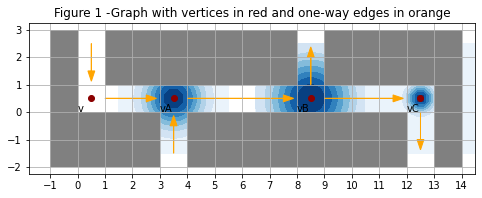

In [33]:
# need X, Y, Z for each p(x=v_j| N(v_j, Sigma))  
def determine_points(mu, N=5):
    X = np.linspace(mu[0]-2, mu[0]+2, N)
    Y = np.linspace(mu[1]-2, mu[1]+2, N)
    X,Y = np.meshgrid(X,Y)
    pos = np.empty(X.shape + (2,))
    pos [:,:,0] = X
    pos [:,:,1] = Y
    return X, Y, pos

fig, ax = plt.subplots(figsize=(8,5))

# building layout
building1 = plt.Rectangle((1,1), 7, 2, fc='grey')
building2 = plt.Rectangle((4, -2), 8, 2, fc='grey')
building3 = plt.Rectangle((9,1), 5, 2, fc='grey')
building4 = plt.Rectangle((13,-2), 1, 3, fc='grey')
building5 = plt.Rectangle((-1,-2), 1, 5, fc='grey')
building6 = plt.Rectangle((0,-2), 3, 2, fc='grey')
plt.gca().add_patch(building1)
plt.gca().add_patch(building2)
plt.gca().add_patch(building3)
plt.gca().add_patch(building4)
plt.gca().add_patch(building5)
plt.gca().add_patch(building6)

# one-way streets
plt.arrow(0.5, 2.5, 0, -1, head_width=0.25, color='orange')
plt.arrow(8.5, 1, 0, 1, head_width=0.25, color='orange')
plt.arrow(3.5, -1.5, 0, 1, head_width=0.25, color='orange')
plt.arrow(12.5, 0, 0, -1, head_width=0.25, color='orange')
plt.arrow(1, 0.5, 1.5, 0, head_width=0.25, color='orange')
plt.arrow(4, 0.5, 3.5, 0, head_width=0.25, color='orange')
plt.arrow(9, 0.5, 2.5, 0, head_width=0.25, color='orange')

#plot gaussian distribution for each intersection/vertex:
# a = 
# my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
# my_cmap[:,0:3] *= a 
# my_cmap = ListedColormap(my_cmap)

for i, v in enumerate(V):
    if i == 0:
        continue
    X, Y, pos = determine_points(v, 20)
    Sigma = np.array([[var[i],0],[0,var[i]]])
    Z = multivariate_normal.pdf(pos, v, Sigma)
    plt.contourf(X, Y, Z, cmap='Blues')

# plot intersections/vertices
plt.scatter([0.5, 3.5, 8.5, 12.5], [0.5, 0.5, 0.5, 0.5], 
            c='darkred', marker='o')

# add annotation to the intersections/vertices
intersections = ['v', 'vA', 'vB', 'vC']
locations = [(0, 0), (3, 0), (8, 0), (12, 0)]
for i, location in enumerate(locations):
    plt.annotate(intersections[i], location)

# final formatting
plt.grid()
plt.xticks(np.arange(-1, 15))
plt.yticks(np.arange(-2,4))
plt.title('Figure 1 -Graph with vertices in red and one-way edges in orange')
plt.axis('scaled')
plt.savefig('figure_1_graph.png', dpi=550)
plt.show()

In [47]:
def compute_prob(v, var, integration_range):
    def pdf(*args):
        x = np.array(args)
        return multivariate_normal.pdf(x, mean=mean, cov=cov)
    X, Y, pos = determine_points(v, 20)
    mean = v
    cov = np.array([[var, 0],[0, var]])
    output, _ = nquad(pdf, integration_range)
    return output

integration_range = [[[0,1],[0,1]],[[3,4],[0,1]],[[8,9],[0,1]], [[12,13],[0,1]]]

for i, v in enumerate(V):
    if i ==0:
        continue
    result = compute_prob(v, var[i], integration_range[i])
    print("p_detect v_",i, '= ', round(result, 3))

p_detect v_ 1 =  0.271
p_detect v_ 2 =  0.147
p_detect v_ 3 =  0.785


We can now compute the posterior $p(x|v, a)$ of taking action a at intersection v:

$p(x|v,a) = \sum_{j=1}^{|J|}(N(v_j,\Sigma_{j|i,a})p_{detect}(v_j|v,a)\cdot\prod_{k=1}^{j-1}(1-p_{detect}(v_k|v,a)))$

where:
 * $J$: is the ordered set of subsequent intersections that the robot may reach if it misses the previous intersection

For our example:

 
OR....
 * $x=(3,0) \longrightarrow p(x|v,a)$ 
 * $J= \{v_A, v_B, v_C\}$, so $|J|=3$
 

 $p(x|v,a) = $
 * **(j=1)**: $N(v_A, \Sigma_{A|v,a})\cdot p_{detect}(v_A|v,a) +$
 * **(j=2, k=1)**: $N(v_B, \Sigma_{B|v,a})\cdot p_{detect}(v_B|v,a)\cdot(1-p_{detect}(v_A|v,a))+ $
 * **(j=3,k=1,2)**: $N(v_C, \Sigma_{C|v,a})\cdot p_{detect}(v_C|v, a)\cdot (1-p_{detect}(v_A|v,a))\cdot(1-p_{detect}(v_B|v,a))$


In [44]:
integration_range2 = [[3,4],[0,1]]
N_A = []

for i, v in enumerate(V):
    if i == 0:
        continue
    result = compute_prob(v, var[i], integration_range2)
    N_A.append(result)
print(N_A)


[0.27092012280339645, 1.293782141394298e-06, 1.6963660607487089e-159]


In [49]:
p_dA = 0.271
p_dB = 0.147
p_dC = 0.785

prob_xA = 3.5*p_dA + 8.5*p_dB*(1-p_dA) + 12.5*p_dC*(1-p_dB)*(1-p_dC)
print(prob_xA)
      
prob_xB = 8.5*p_dB + 12.5*p_dC*(1-p_dB)
print(prob_xB)

prob_xC = 12.5*p_dC
print(prob_xC)

3.6589489375
9.619562499999999
9.8125


#### <u>Part 2 - Posterior starting at a state</u>

Now we are looking at the input position of the robot (the initial state) is represented by the belief (A-MDP) state $s \in S$

The posterior of taking an action is all the possible transitions that may occur.  Therefore:

$p(x|s,a)=\eta \sum_{i=1}^{|V|}p(x=v_i|s)p(x|v_i,a)$

where:
 * $\eta$: is a normalization factor

We calculated $p(x|v_i, a) \forall a \in A, \forall v_i \in V$ in the previous part.

The probability of p(x=v_i|s) is only 1 if v_i corresponds with s.


#### <u>Part 3 - State Transitions </u>

The transition probability of taking an action a from an A-MDP state s to another state s' is found by computing the posterior belief of each.

$T(s'|s,a)=\eta\cdot exp(-D_B(p(x|s,a),p(x|s'))$

where:
 * $D_B$: is the Bhattacharyya distance, which is a measure of the similarity/overlap between two distributions.

### Step 5. Reward Function (R)

$r(v_i,a,v_k) = -r_{noroad}$